In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy.spatial import cKDTree
from nalger_helper_functions import *

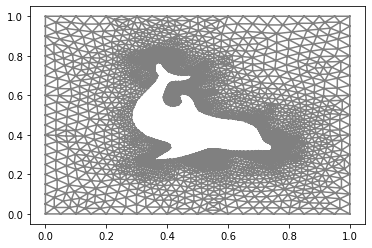

In [2]:
mesh_type = 'dolfin'

if mesh_type == 'dolfin':
    mesh = dl.Mesh("dolfin-2.xml.gz")
elif mesh_type == 'circle':
    mesh_center = np.array([0.5, 0.5])
    mesh_radius = 0.5
    mesh_h = 3e-2 # 7.5e-3 # 2.5e-2 # 1e-2
    mesh = circle_mesh(mesh_center, mesh_radius, mesh_h)
else:
    n = 25
    mesh = dl.UnitSquareMesh(n,n)
    
dl.plot(mesh)

In [3]:
V = dl.FunctionSpace(mesh, 'CG', 1)
dof_coords = V.tabulate_dof_coordinates()

u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

derivative_direction = np.array([1., 0.5])

xhat = dl.Expression(("a", "b"), a=derivative_direction[0], b=derivative_direction[1],
                     domain=mesh, degree=5)
Dx_true = csr_fenics2scipy(dl.assemble(v_test * dl.inner(xhat, dl.grad(u_trial)) * dl.dx))
Dx_true = Dx_true + 0.0 * (1j * Dx_true)

M = csr_fenics2scipy(dl.assemble(u_trial * v_test * dl.dx))
M = M + 0.0 * (1j * M)
solve_M = spla.factorized(M)

Dx_true_coo = Dx_true.tocoo()

# Dx_true_dense = Dx_true.toarray()

q_true = Dx_true_coo.data.real
rows_true = Dx_true_coo.row
cols_true = Dx_true_coo.col

nq_true = len(q_true)
print('nq_true=', nq_true)

print('V.dim()=', V.dim())

print(nq_true / (V.dim()**2))

nq_true= 19024
V.dim()= 2868
0.002312829101575797


/home/nick/anaconda3/envs/fenics3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/least_squares_derivative_matrix.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_true[:,k] = apply_D_true(X[:,k])


min_h= 0.0013728568752787136 , mesh_diameter= 1.4142135623730951
nnz= 28680 , np.size(X)= 25812
s= 1e-07 , err_D_prime_mode3_contraction= 1.7808790879160308e-09
s= 1e-15 , err_grad= 1.0213507795057042 , err_hess= 0.13540437072080747
s= 1e-14 , err_grad= 1.2135077950570412 , err_hess= 0.013908368252089508
s= 1e-13 , err_grad= 0.2883073498098624 , err_hess= 0.0013927419218849263
s= 1e-12 , err_grad= 0.05107646641314983 , err_hess= 0.00014118455688451477
s= 1e-11 , err_grad= 0.0023840143523065215 , err_hess= 1.4126107717114544e-05
s= 1e-10 , err_grad= 0.000270766254585566 , err_hess= 1.4003761745497902e-06
s= 1e-09 , err_grad= 3.651080581400029e-05 , err_hess= 1.486536056130085e-07
s= 1e-08 , err_grad= 9.598842137575055e-07 , err_hess= 1.5625892051562504e-08
s= 1e-07 , err_grad= 5.597283837076055e-06 , err_hess= 1.5585620923737528e-09
s= 1e-06 , err_grad= 5.1125136073600056e-05 , err_hess= 1.547349076884064e-10
s= 1e-05 , err_grad= 0.0005130432183773199 , err_hess= 1.553581320270555e-11
s

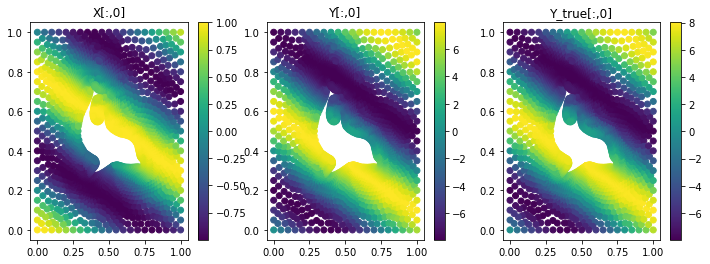

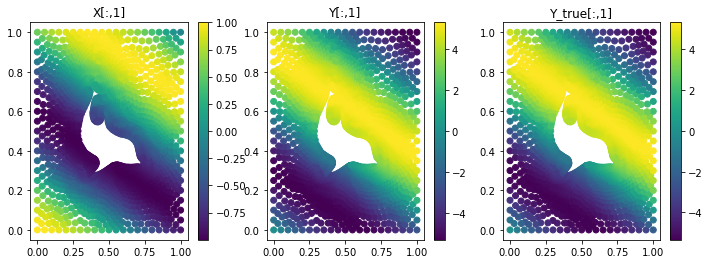

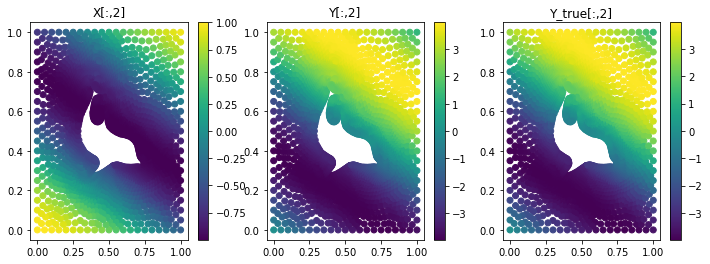

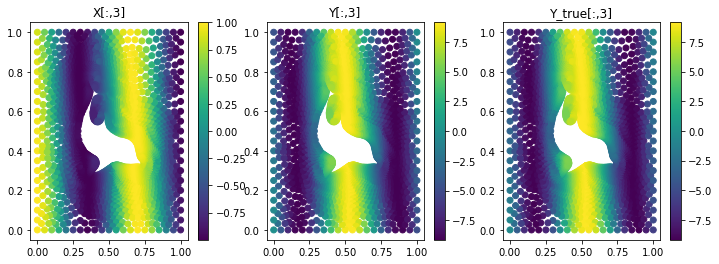

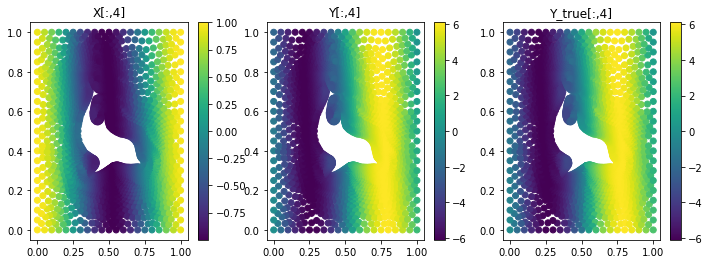

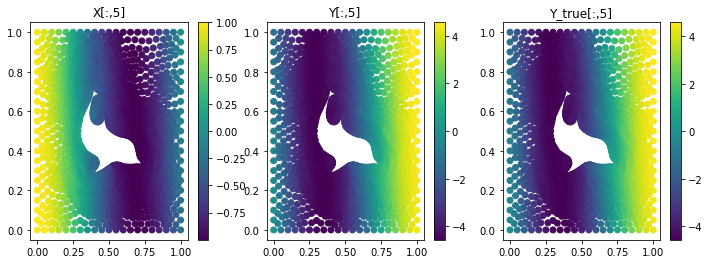

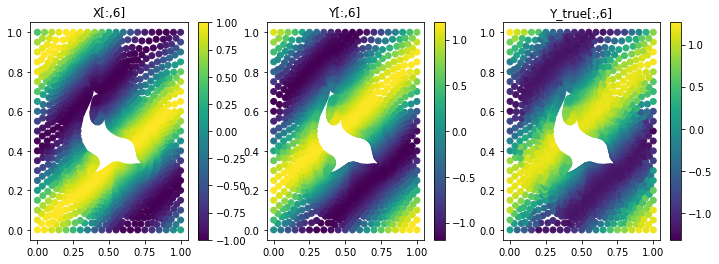

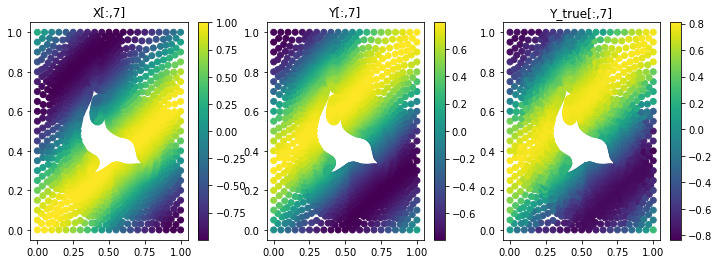

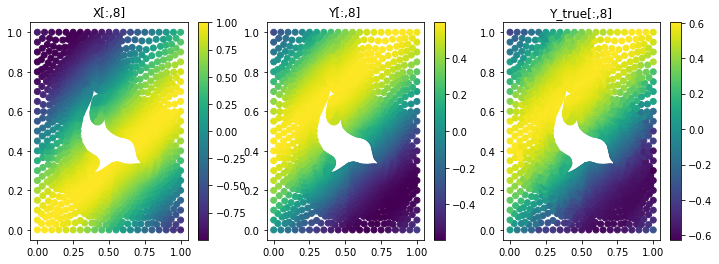

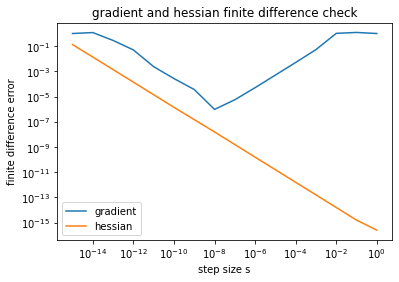

In [4]:
Dx = least_squares_directional_derivative_matrix(dof_coords, derivative_direction,
                                                 a_reg=1e-6, num_neighbors=10,
                                                 num_angles=3, num_frequencies=3,
                                                 min_points_per_wavelength=30,
                                                 plot_probing_functions=True,
                                                 apply_D_true=lambda x: solve_M(Dx_true * x),
                                                 run_finite_difference_checks=True)

err_df_dx= 0.03166461896914849


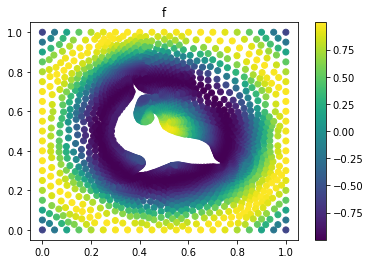

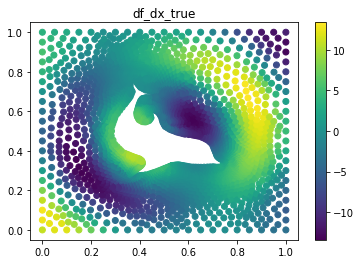

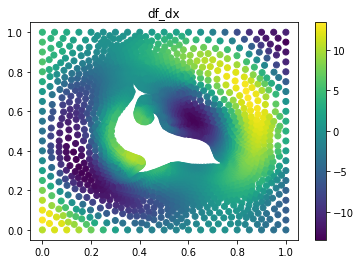

In [5]:
f = np.cos(12 * np.linalg.norm(dof_coords - 0.5, axis=1))

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

In [15]:
sqrt_LM = sps.diags(np.sqrt(M.diagonal())).tocsr()

z = np.random.randn(M.shape[0])

err_lumped_mass_sqrt = np.linalg.norm(sqrt_LM * (sqrt_LM * z) - M * z) / np.linalg.norm(z)
print('err_lumped_mass_sqrt=', err_lumped_mass_sqrt)

err_lumped_mass_sqrt= 9.482888636108461e-05


err_df_dx= 0.050416175499360324


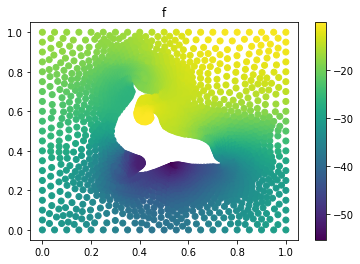

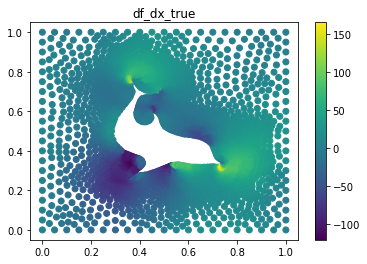

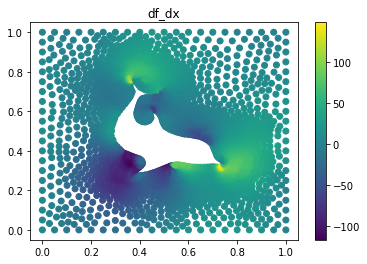

In [17]:
A = csr_fenics2scipy(dl.assemble(dl.inner(dl.grad(u_trial), dl.grad(v_test))*dl.dx + 10.*u_trial*v_test*dl.dx))

f = spla.spsolve(A * A, sqrt_LM * np.random.randn(V.dim()))

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

err_df_dx= 0.6030463812344238


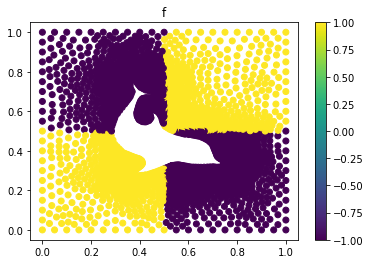

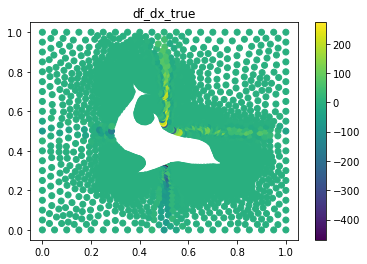

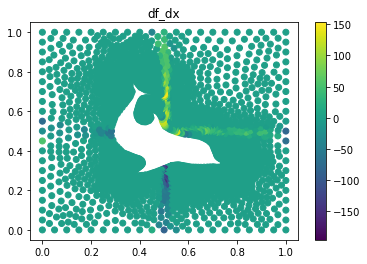

In [7]:
f1 = 2. * (dof_coords[:,0] > 0.5) - 1
f2 = 2. * (dof_coords[:,1] > 0.5) - 1
f = f1 * f2

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

In [8]:
v1 = (M * Dx).getrow(0).toarray().real.reshape(-1)

np.argwhere(np.abs(v1) > 1e-10).reshape(-1)

v2 = Dx_true.getrow(0).toarray().real.reshape(-1)

np.argwhere(np.abs(v2) > 1e-10).reshape(-1)

np.vstack([v1[:10], v2[:10]]).T

array([[-2.58315672e-05,  7.16666667e-06],
       [ 3.97719130e-05,  3.41333333e-04],
       [-1.99710169e-05, -7.16666667e-06],
       [-9.72770614e-05, -3.41333333e-04],
       [ 7.53061492e-05,  0.00000000e+00],
       [ 3.33083377e-05,  0.00000000e+00],
       [-1.49800683e-05,  0.00000000e+00],
       [-8.42394343e-05,  0.00000000e+00],
       [-1.48122112e-05,  0.00000000e+00],
       [ 7.00855689e-05,  0.00000000e+00]])